<a href="https://colab.research.google.com/github/Hilbert-HN/HN_ML_From_Scratch/blob/main/playground_AI/01_AI_on_Cristiano_Ronaldo/MulitPose_MoveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial: https://www.youtube.com/watch?v=KC7nJtBHBqg \
tensorflow-hub: https://tfhub.dev/ \
tensorflow-hub [movenet/multipose/lightning]: https://tfhub.dev/google/movenet/multipose/lightning/1

# **0. Install and Import Dependencies**

**use movenet/multipose/lightning from tensorflow-hub**

In [1]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 tensorflow-hub

In [2]:
# !pip install opencv-python matplotlib

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [4]:
# Optional if you are using a GPU
# limit the memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **1. Load "Movenet-Multipose" Model from Tensflow Hub**

In [6]:
# Refer to "Usage" section in documentation in Tensorflow hub
# https://tfhub.dev/google/movenet/multipose/lightning/1

model = hub.load("https://tfhub.dev/google/movenet/multipose/lightning/1")
movenet = model.signatures['serving_default']

# **2. Make Detections**

## Keypoint and edge Drawing Functions

In [7]:
# Function to loop through each person detected and redner 
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
  for person in keypoints_with_scores:
    draw_connections(frame, person, edges, confidence_threshold)
    draw_keypoints(frame, person, confidence_threshold)
  return frame

In [8]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [9]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 6, (0,255,0), -1)

In [10]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 4)

## For Video Detection on Colab

In [11]:
video_name = 'C Ronaldo_.mp4'
# video_name = 'novak.mp4'

In [12]:
# Read video with openCV
cap = cv2.VideoCapture(video_name)

# Get video total number of frame
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('Total num of frames: ', length)

# Get video rrames per second
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
if int(major_ver)  < 3 :
    fps = cap.get(cv2.cv.CV_CAP_PROP_FPS)
else :
    fps = cap.get(cv2.CAP_PROP_FPS)
print('Frames per second: ' ,fps)

# Get video frames size
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape
print('Frame size (HXW):', frame_height, 'x', frame_width)
print('Aspect ratio: ', frame_height / frame_width)

## Resize image for Detection
# image size to be in multiple of 32
# close to original aspect ratio
# longer side be 256

# python 3 roudn 4.5 to 4, we prefer round 4.5 to 5
from decimal import Decimal, ROUND_HALF_UP

longer_side = 960 #256 #640
#256 was found too inaccurate
if (frame_height > frame_width):
  frame_height_resize = longer_side

  short_side = (frame_width / frame_height) * longer_side
  short_side = int(Decimal(short_side/32).to_integral_value(rounding=ROUND_HALF_UP)*32)
  frame_width_resize = short_side

else:
  short_side = (frame_height / frame_width)*longer_side
  short_side = int(Decimal(short_side/32).to_integral_value(rounding=ROUND_HALF_UP)*32)
  frame_height_resize = short_side

  frame_width_resize = longer_side

print('Frame resized (HXW):', frame_height_resize, 'x', frame_width_resize)
print('Aspect ratio resied: ', frame_height_resize / frame_width_resize)

cap.release()

Total num of frames:  362
Frames per second:  29.97002997002997
Frame size (HXW): 1080 x 1920
Aspect ratio:  0.5625
Frame resized (HXW): 544 x 960
Aspect ratio resied:  0.5666666666666667


In [13]:
# Read video with openCV
cap = cv2.VideoCapture(video_name)

# Set number of frame to analysis
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# length = 360
output_bool = True

# Print Progress bar while processing video
from tqdm import tqdm  

# timestamp for output video name
if output_bool == True:
  import datetime
  now = datetime.datetime.now()
  dt_string = now.strftime("%m%d_%H%M%S")
  output_video_name = 'output_' + dt_string + '.avi'
  print("Output Video Name: ", output_video_name)

# Store the Frame
frames = []
frame_index = 0

# add this for writing video
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape

if output_bool == True:
  # out = cv2.VideoWriter(output_video_name,cv2.VideoWriter_fourcc('M','P','4','V'), fps, (frame_width,frame_height))
  out = cv2.VideoWriter(output_video_name,cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))

print("Processing Video...")
while cap.isOpened():
  # Print progress bar for video
  for i in tqdm(range(length)):

      ret, frame = cap.read()

      # if no frame is found
      if not ret:
        cap.release()
        break
      
      # Resize image
      img = frame.copy()
      img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), frame_height_resize, frame_width_resize)
      input_img = tf.cast(img, dtype=tf.int32)
      
      # Detection section
      results = movenet(input_img)
      keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
      
      # Render keypoints 
      output_frame = loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)

      # for viewing the image
      frames.append(output_frame)
      
      # for output as video
      if output_bool == True:
        out.write(output_frame)

      ## Pause Video at earlier frame
      frame_index += 1 
      if frame_index == length:
        cap.release()
        break

cap.release()
print("\nDone processing video")

Output Video Name:  output_0531_184835.avi
Processing Video...


100%|█████████▉| 361/362 [00:32<00:00, 11.10it/s]


Done processing video


101


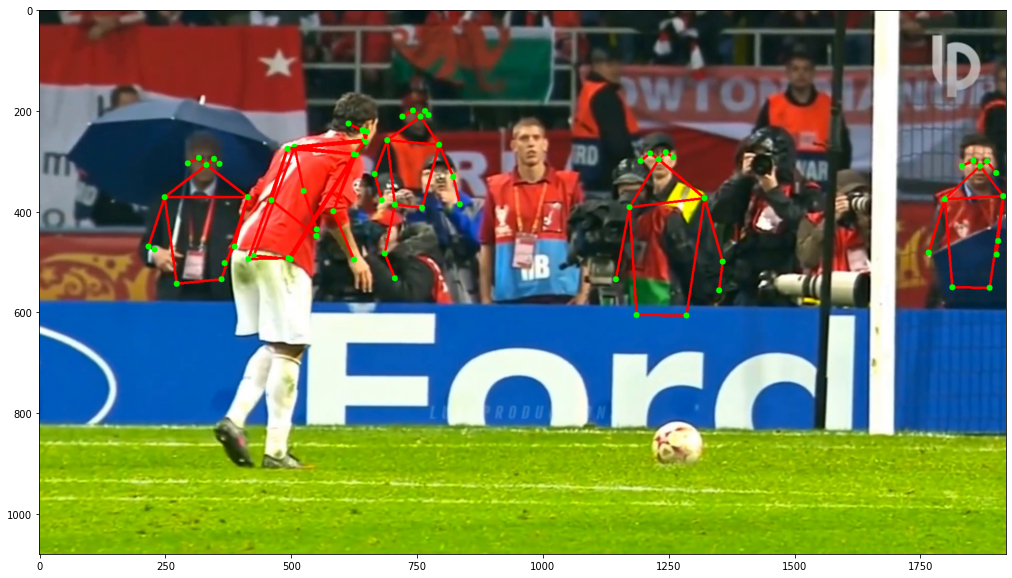

In [36]:
import random
frame_index = random.randint(0,length)
frame = frames[frame_index]

print(frame_index)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

## For Cam onColab

To allow Webcam / Video analysis work on Colab. \
You will required below codes



### Import dependencies

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

### Helper Functions - Image / Video

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Running on Webcam Video

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 

# cap = cv2.VideoCapture('novak.mp4')

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])


    # -----------Add below bbox_array to render something on top of the CAM / video---------------
    # Also add bbox_array to your rendering functions
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # -----------input your own code below----------------
    ## Resize image
    # image size to be in multiple of 32
    # close to original aspect ratio
    # longer side be 256
    img = frame.copy()
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 192, 256)
    input_img = tf.cast(img, dtype=tf.int32)

    # Detection section
    results = movenet(input_img)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape(6,17,3)

    # Render keypoints
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.3, bbox_array)

    # -----------Add below bbox_array to render something on top of the CAM / video---------------
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

**The order of the 17 keypoint joints is:** \
[nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle]. \

**The remaining 5 elements** \
[ymin, xmin, ymax, xmax, score]

In [ ]:
# Function to loop through each person detected and redner 
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, bbox_array):
  for person in keypoints_with_scores:
    draw_connections(frame, person, edges, confidence_threshold, bbox_array)
    draw_keypoints(frame, person, confidence_threshold, bbox_array)

# **2a. Debuggig**

In [ ]:
# show the frame captued and convert to right color channel order in openCV
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [ ]:
results.keys()
# key: output_0
# shape=(1, 6, 56)
# 6 people, [17 keypoints (each keypoint consist on x,y,score) = 51 + 5 bounding box] = 56
# get the first 51 keypoints
# reshape so the matrix show 6 people, with 17 keypoints with 3 values
results['output_0'].numpy()[:,:,:51].reshape((6,17,3))

array([[[7.71245599e-01, 7.83745825e-01, 2.89876133e-01],
        [6.55809641e-01, 8.59675825e-01, 3.66784483e-01],
        [6.68464661e-01, 6.77065611e-01, 5.00870466e-01],
        [6.91803873e-01, 9.33493733e-01, 4.12414186e-02],
        [7.02996254e-01, 5.59518754e-01, 3.67192566e-01],
        [8.77185822e-01, 9.19583797e-01, 2.36720103e-03],
        [8.47760737e-01, 4.56126571e-01, 2.19837382e-01],
        [7.36677051e-01, 9.60782886e-01, 1.90645624e-02],
        [8.70474398e-01, 3.04133087e-01, 5.89331686e-02],
        [6.61943138e-01, 8.68139029e-01, 4.11501229e-02],
        [7.24192142e-01, 4.76850778e-01, 1.78363994e-02],
        [8.58069956e-01, 6.51545644e-01, 1.47443516e-02],
        [8.79938781e-01, 4.48165447e-01, 8.78432300e-03],
        [7.46429980e-01, 8.90855849e-01, 7.46415171e-04],
        [7.75877774e-01, 5.59283614e-01, 7.90146738e-02],
        [4.20849174e-01, 6.12614989e-01, 3.95057490e-03],
        [4.51202542e-01, 5.33603728e-01, 1.02784941e-02]],

       [[7.7

In [ ]:
# keypoint of first person
keypoints_with_scores[0]

array([[7.1295965e-01, 7.9407114e-01, 4.6980116e-01],
       [5.9965909e-01, 8.5591871e-01, 5.4849637e-01],
       [6.0389894e-01, 6.7563164e-01, 5.5109423e-01],
       [6.4719439e-01, 8.7866950e-01, 4.0800408e-02],
       [6.4391869e-01, 5.3318614e-01, 4.3820333e-01],
       [8.7057215e-01, 8.7538195e-01, 2.7269499e-02],
       [8.6764216e-01, 3.2354763e-01, 3.5445666e-01],
       [8.3974141e-01, 8.9413124e-01, 1.2316870e-02],
       [8.7059027e-01, 2.9584390e-01, 1.7361097e-02],
       [6.6337019e-01, 8.8659084e-01, 9.8222159e-02],
       [7.4100393e-01, 5.3474063e-01, 2.1906585e-02],
       [8.7246090e-01, 6.2498808e-01, 3.7731538e-03],
       [8.8461286e-01, 4.2799258e-01, 2.4132668e-03],
       [6.7941916e-01, 9.1377860e-01, 6.4175618e-03],
       [7.4849123e-01, 6.0424829e-01, 8.7541990e-02],
       [3.2529619e-01, 7.8545558e-01, 2.6253273e-03],
       [3.4925783e-01, 6.8339717e-01, 6.3009548e-04]], dtype=float32)

In [ ]:
# calculate the to reshape
print(frame.shape)
print(480/640)
print(256*0.75)
print(192/32)

(480, 640, 3)
0.75
192.0
6.0


# **3. Draw Keypoints**

In [ ]:
def draw_keypoints(frame, keypoints, confidence_threshold, bbox_array):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            # cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 
            bbox_array = cv2.circle(bbox_array, (int(kx), int(ky)), 4, (0,255,0), -1) 

# **4. Draw Edges**

In [ ]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [ ]:
def draw_connections(frame, keypoints, edges, confidence_threshold, bbox_array):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            #cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
            bbox_array = cv2.line(bbox_array, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)